# CV PROJECT: VISUAL INSPECTION OF MOTORCYCLE CONNECTING RODS

Completed around November 2021 by:

Gianmarco Canello

Marco Roncato

Stefano Bortolotti

Stefano Mulargia


# TASKS

For each connecting rod appearing in the image, the vision system should provide the following information:  
 
1. Type of rod (type A = rod with 1 hole or type B = rod with 2 holes). 

2. Position and orientation (modulo $\pi$). 

3. Length $(L)$, Width $(W)$, Width at the barycenter $(W_B)$.

4. For each hole, position of the center and diameter size.  
 

# LIBRARIES

In [581]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from scipy.spatial import distance

%matplotlib inline 

print("The NumPy version is:", np.__version__)
print("The OpenCV version is:", cv2.__version__)

The NumPy version is: 1.23.4
The OpenCV version is: 4.6.0


# IMAGE IMPORTATION

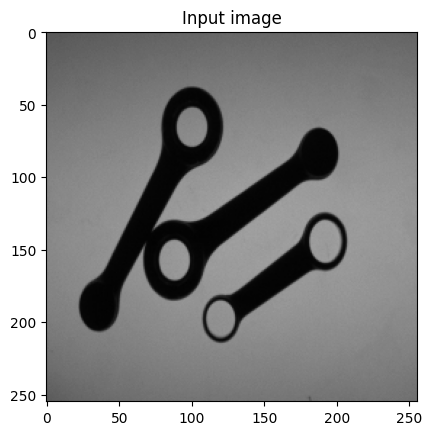

In [582]:
# all images: 00 01 12 21 31 33 44 47 48 49 50 51 90 92 98
# where:
# 50 51 connected rods
# 90 92 98 presence of powder

image_to_load = 'images/TESI50.BMP'

image = cv2.imread(image_to_load,cv2.IMREAD_GRAYSCALE) 

plt.imshow(image, cmap='gray', vmin=0, vmax=255);
plt.title("Input image")
plt.show()

# HISTOGRAM STRETCHING

We decide to use a *linear contrast stretching* in order to increase the constrast of the image and enhance the backlight because the background of some images is too dark (TESI01,12,21,31,33,50,51).

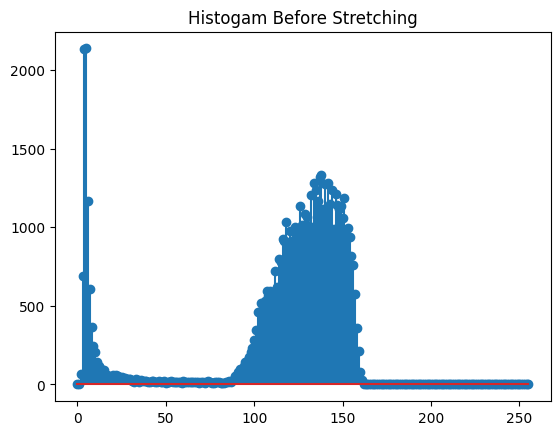

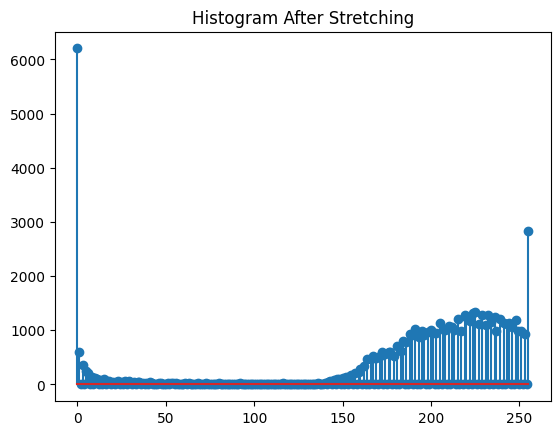

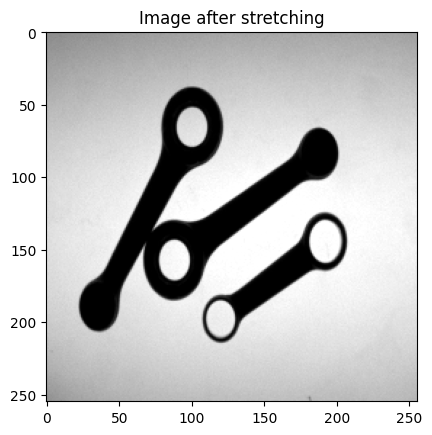

In [583]:
# Function and plotting taken from Lab session (credit)

def linear_stretching(img, max_value, min_value):
    img[img<min_value] = min_value
    img[img>max_value] = max_value
    linear_stretched_img = 255./(max_value-min_value)*(img-min_value)
    return linear_stretched_img


def find_percentile_value(hist, percentile):
    s = 0
    idx = 0
    total_pixel = np.sum(hist)
    while(s < total_pixel*percentile/100):
        s += hist[idx]
        idx += 1
    return idx


# Extracting the histogram
hist,bins = np.histogram(image.flatten(),256,[0,256])

# Plotting the histogram before stretching
plt.show()
plt.title("Histogam Before Stretching")
plt.stem(hist)
plt.show()


# Stretching with dynamic max and min based on percentiles.
max_value = find_percentile_value(hist, 95)
min_value = find_percentile_value(hist, 5)
# print("Max 95%: ", max_value, " Min 5%: ", min_value)
linear_stretched_img = linear_stretching(np.copy(image), max_value,min_value)
hist_st,bins = np.histogram(linear_stretched_img.astype(np.uint8).flatten(),256,[0,256])

image_s = linear_stretched_img

# Plotting the histogram after stretching
plt.show()
plt.title("Histogram After Stretching")
plt.stem(hist_st)
plt.show()

plt.imshow(linear_stretched_img,cmap='gray',vmin=0,vmax=255)
plt.title("Image after stretching")
# plt.savefig(f'out_linear_stretched_img_{image_to_load}.png')
plt.show()

# IMAGE FILTERING
The second thing to do is to deal with noise.

We can deal with the scattered iron powder as if it was an ***impulsive noise*** (salt and pepper noise), by emploing a ***median filter***. It could be also employed a gaussian filter, but due to the hypotesis on the noise we stick with the median filter.

In general a single median filter is not able to remove completely the noise, to solve this we implemented another algorithm (`cv2.fillConvexPoly`) that later will also fill (with black, so remove) the other extraneous objects like screws and washers.

The following function `check_powder` returns a bool variable if the image binarized has many elements inside of it. This is sort of an heuristic evaluation since we noticed that usually in a clean image the number of contours is small. The value that determines if there is powder in the image is that there are more than 10 contours.

We decide to implement this simple heuristic function instead of looking for the dimension of the area for computational reasons.

We chose the standard `cv2.threshold` method because we found it to be a good solution for binarizing our image.

Powder present in the image: False


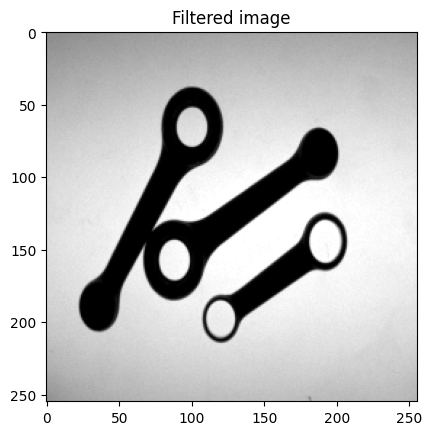

In [584]:
def check_powder(img):
    _,image_b_ = cv2.threshold(img.astype(np.uint8),0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    contours_, _ = cv2.findContours(image_b_, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    if len(contours_) > 10:
        powder_present = True
    else:
        powder_present = False

    return powder_present

powder = check_powder(image_s.astype(np.uint8))
image_f = image_s.astype(np.uint8)

if powder == True:
    image_f = cv2.medianBlur(image_f, 3)

print("Powder present in the image:", powder)

plt.imshow(image_f, cmap='gray', vmin=0, vmax=255);
# plt.savefig(f'out_filtered_{image_to_load}.png')
plt.title("Filtered image")
plt.show()

# BINARIZATION

In order to deal with different lighting levels we use a binary threshold with an ***Otsu algorithm***. We found that the Otsu algorithm is the best to binarize the image in our application since it chooses the threshold level that will minimize the Within-group Variance and it has the fastest computation time with respect to the adaptive thresholding method.

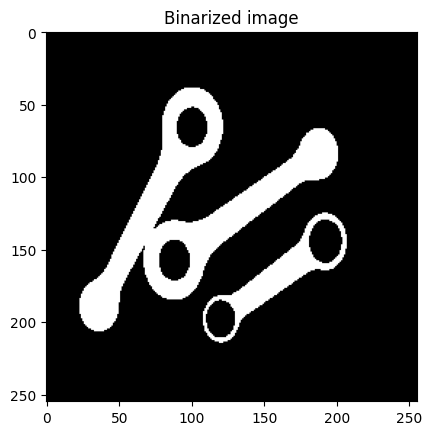

In [585]:
_,image_b = cv2.threshold(image_f.astype(np.uint8),0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

plt.imshow(image_b, cmap ='gray', vmin = 0, vmax = 255)
# plt.savefig(f'out_binarized_{image_to_load}.png')
plt.title("Binarized image")
plt.show()

# BARYCENTER FUNCTIONS

The following function considers two tipes of barycenters:

- the one given by the contours (`countours_func`)
- the one given by the area (`centroids_func`)

The argument `cv2.RETR_TREE` retrieves all the contours and creates a full family hierarchy list of the nested contours, while `cv2.CHAIN_APPROX_NONE` defines the contour-approximation method. In this way we have a slower execution of the algorithm with respect to the other possible argument `cv2.CHAIN_APPROX_SIMPLE` but we detect all contours, because we need them to filter out every possible distraction from the image.

We computed a final Barycenter dictionary filled with the barycenter from the contours for the holes and from the area for the rods by computing the distance between the various contours. If this distance is the minimum value from all the other barycenters then the barycenters must be referred to the same object/hole so the dictionary can be updated without the repeating barycenters.


In [586]:
def Barycenter_computation(img_func,Barycenter_contours_func,Barycenter_func):

    ############## BLOB Barycenter ################
    [_, _, _, centroids_func] = cv2.connectedComponentsWithStats(img_func, connectivity=8)  # considering chessboard connectivity we just pick the barycenter coordinates
    centroids_func = centroids_func.astype(int)     # we convert as int just for clarity
    


    ############# CONTOUR Barycenter ############### # here the barycenter is estimated BY THE CONTOURS ONLY (NOT CONSIDERING THE LOSS OF MATERIAL)
    contours_func, hierarchy_func = cv2.findContours(img_func, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) # retrieves contours from the binary image and creates a family hierarchy list of the nested contours
    # https://docs.opencv.org/3.4/d9/d8b/tutorial_py_contours_hierarchy.html

    for c in range(len(contours_func)):
        Barycenter_contours_func[c] = [int(sum(contours_func[c][:,0][:,0])/len(contours_func[c][:,0][:,0])), int(sum(contours_func[c][:,0][:,1])/len(contours_func[c][:,0][:,1]))] # che succede qui ???



    ################ UNIFICATION DICTIONARY #################
    for i in range(len(contours_func)): # we go through the family of contours
        temp = 0
        dst_min = 10000     # just to set a distance value higher than all the reasonable value we can get
        if hierarchy_func[0][i][3] == -1:   # if there are no parents (i.e. we're dealing with rods or foreign items, so we do not consider holes)
            for j in range(len(centroids_func)): # we go through the blobs
                dst = distance.euclidean(centroids_func[j], Barycenter_contours_func[i]) 
                if dst < dst_min:   # we search the considered i-th rod TRUE barycenter by searching the minimum distance between its barycenter evaluated by contours and the closest one in the TRUE barycenter array considering HOLES 
                    dst_min = dst
                    temp = j
            Barycenter_func[i] = centroids_func[temp]
        else:   # if we're dealing with holes
            Barycenter_func[i] = Barycenter_contours_func[i] # if it's an hole and then i can use the contours to evaluate the barycenter
    
    

    return contours_func, hierarchy_func, Barycenter_func, Barycenter_contours_func



# Here we use the function previously defined

Barycenter_contours_preproc = {}    # dictionary with barycenter coordinates (only the ones computed considering the contours)
Barycenter_preproc = {}             # dictionary with barycenter coordinates (already sorted in "unification dictionary")
contours_preproc, hierarchy_preproc, Barycenter_preproc, Barycenter_contours_preproc = Barycenter_computation(image_b, Barycenter_contours_preproc, Barycenter_preproc)

print(Barycenter_contours_preproc)
print(Barycenter_preproc)

{0: [157, 169], 1: [119, 197], 2: [191, 144], 3: [100, 122], 4: [87, 157], 5: [99, 65]}
{0: array([158, 168]), 1: [119, 197], 2: [191, 144], 3: array([101, 122]), 4: [87, 157], 5: [99, 65]}


## Detection of POWDER and SCREWS

In the following section we compute a dictionary with the contour of the POWDER (and the SCREWS) that we will use later to remove completely the one remained after the median filter.

In order to do that we exploit the hierarchy of the object obtained with the functon `findContours`.

The first `if` filters the objects with no hole that are outside the rods. (We count the powder and the screws)

The second `if` filters the contours of the powder inside the holes of the rods. (because we know that any object inside of the holes of the rods is a distraction)

Once the dictionary is completed, we use `fillConvexPoly` to fill all the blobs that have no holes (screw and powder)

In [587]:
Dict_contour_powder = {}
# Hierarchy structures [Next, Previous, First_Child, Parent] 

for i in range(len(contours_preproc)): 
    if (hierarchy_preproc[0][i][2] == -1) and (hierarchy_preproc[0][i][3] == -1):   # if that contour has no children and no parents
        # hierarchy_preproc[0][i][2] == -1  means object "i" has no child
        # hierarchy_preproc[0][i][3] == -1  means object "i" has no parent
        # The powder is in the background
        Dict_contour_powder[i] = i # memorize the "name" (index)
    
    if (hierarchy_preproc[0][i][3] != -1) and (hierarchy_preproc[0][hierarchy_preproc[0][i][3]][3] != -1):
        # hierarchy_preproc[0][i][3] returns the father number, then we see if it exists a grandfather and so it's a powder inside the hole of a rod 
        # hierarchy_preproc[0][hierarchy_preproc[0][i][3]][3] != -1 means that the parent of the parent of object "i" has no parents.
        # The powder is inside a hole
        Dict_contour_powder[i] = i # memorize the "name" (index)

for i in Dict_contour_powder:
    image_b = cv2.fillConvexPoly(image_b,contours_preproc[Dict_contour_powder[i]], color=0)

## Detection of WASHERS
In the following section of code we fill the blobs (WASHERS) that are identified because the barycenter of both child and parent coincide (within 5 pixels as a margin of error).

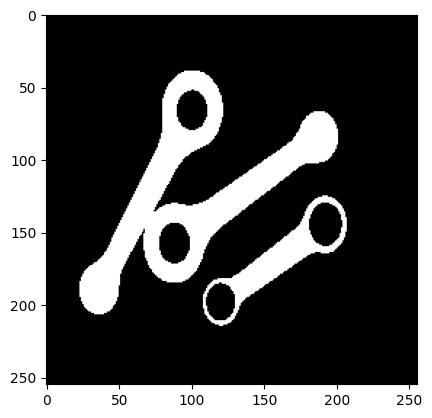

In [588]:
for key in range(0,len(Barycenter_preproc)-1):
    # Compute the euclidian distance between Child and Parent Barycenters
    barycenter = Barycenter_preproc[key]
    barycenter_next = Barycenter_preproc[key+1]
    dist_bar = distance.euclidean((barycenter[0],barycenter[1]), (barycenter_next[0],barycenter_next[1]))

    # If they are close up to a arbitrary distance (chosen by us) fill the Washer. Ideally they shoul be the same but we prefer to stay safe due to possible pixel error.
    if dist_bar<5:
        image_b = cv2.fillConvexPoly(image_b,contours_preproc[key], color=0)


plt.imshow(image_b, cmap='gray', vmin=0, vmax=255)
# plt.savefig(f'out_binarized_clean_{image_to_load}.png')
plt.show()

# WATERSHED (dealing with touching rods)

We start our algorithm applying the ***Distance Transform*** operator that takes a binary image as input. The result of the transform is a graylevel image that looks similar to the input image, except that the graylevel intensities of points inside foreground regions are changed to show the distance to the closest boundary from each point. In other words, the closer the pixel will be wrt the edge the darker it will be.

This will help us in divide connected objects because it highlights the core of the rod and it shadows the touching points.

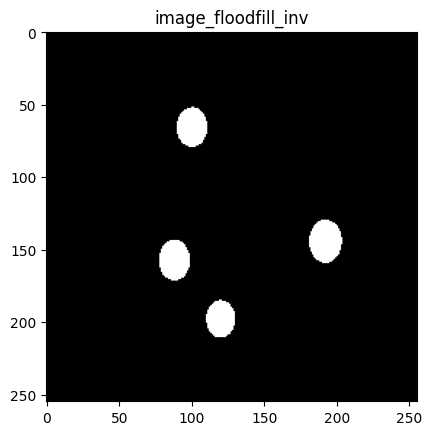

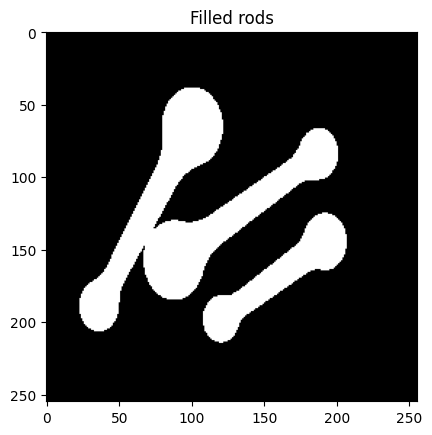

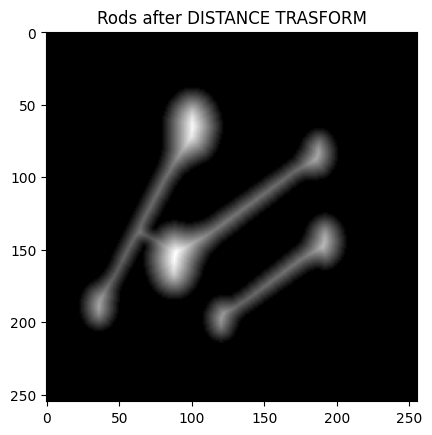

In [589]:
### Blob detection by watershed algorithm

# Copy the thresholded image.
image_floodfill = image_b.copy()

# Mask used to flood filling.
# Notice that the mask size needs to be 2 pixels larger than the image size.
row, column = image_b.shape[:2]
mask = np.zeros((row+2, column+2), np.uint8)

# ??? Floodfill from point (0, 0), detects holes in the binarized image and fills them with white
# Floodfill from point (0,0) "paints" in white all the non-white pixels. When it comes across white pixels, it thinks that its work is done.
# In this way the black holes inside the rods are "protected" by the white rod itself
cv2.floodFill(image_floodfill, mask, (0,0), 255);

# Invert floodfilled image (holes become white and the rest becomes black)
image_floodfill_inv = 255-image_floodfill

plt.imshow(image_floodfill_inv,'gray') 
plt.title('image_floodfill_inv')
plt.show()

# Combine the two images to get the filled rods
image_combined = image_b | image_floodfill_inv

plt.imshow(image_combined,'gray') 
plt.title('Filled rods')
plt.show()

# Apply Distance Transform operator
image_dist_transform = cv2.distanceTransform(image_combined,cv2.DIST_L2,5)

plt.imshow(image_dist_transform,'gray') 
plt.grid(False)
plt.title('Rods after DISTANCE TRASFORM')
plt.show()


# # Extracting the histogram
# hist_image_dist_transform,_ = np.histogram(image_dist_transform.flatten(),256,[0,256])

# # Plotting the histogram before stretching
# plt.title("Hist Before Stretching")
# plt.stem(hist_image_dist_transform, use_line_collection=True)
# plt.show()

We normalize the result to get a consistent thresholding across all images.

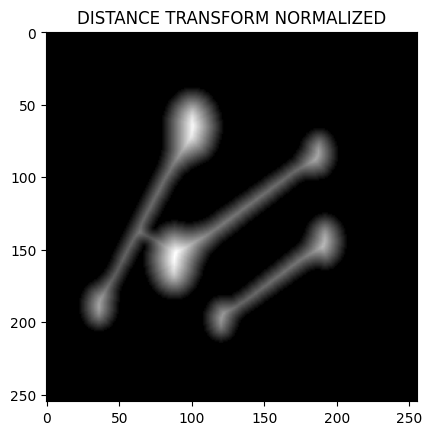

In [590]:
# Normalize the distance image for range = {0.0, 1.0}
# so we can visualize and threshold it
cv2.normalize(image_dist_transform, image_dist_transform, 0.0, 1.0, cv2.NORM_MINMAX)
#Threshold to obtain the peaks

plt.imshow(image_dist_transform,'gray') 
plt.grid(False)
plt.title('DISTANCE TRANSFORM NORMALIZED')
#plt.savefig(f'out_distance_transform_normalized_{image_to_load}.png')
plt.show()


# # Extracting the histogram
# # hist_image_dist_transform,_ = np.histogram(image_dist_transform.flatten(),256,[0,256])

# # Plotting the histogram before stretching
# # plt.title("Hist Before Stretching")
# # plt.stem(hist_image_dist_transform, use_line_collection=True)
# # plt.show()


We set the value of the threshold to 0.34 by trial and error to satisfy the requirements for all the images.

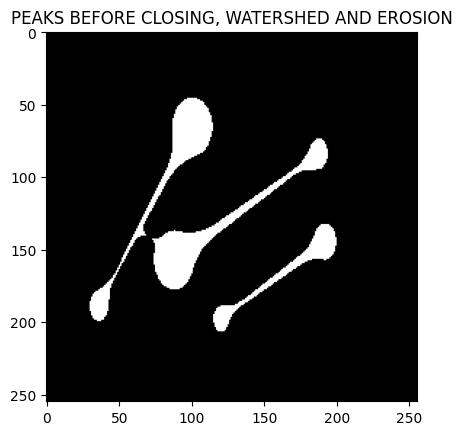

In [591]:
# Thresholding of the normalized distance transform image 
# These will be the markers for the foreground objects (so to lable correctly touching objects with watersheld algorithm)
th, image_b2 = cv2.threshold(image_dist_transform,0.34,1,cv2.THRESH_BINARY)

plt.imshow(image_b2,'gray') 
plt.grid(False)
plt.title('PEAKS BEFORE CLOSING, WATERSHED AND EROSION')
# plt.savefig(f'out_thresholded_{image_to_load}.png')
plt.show()

Now we apply a ***Smart Dilation (Closing)*** to correct the results of the broken parts

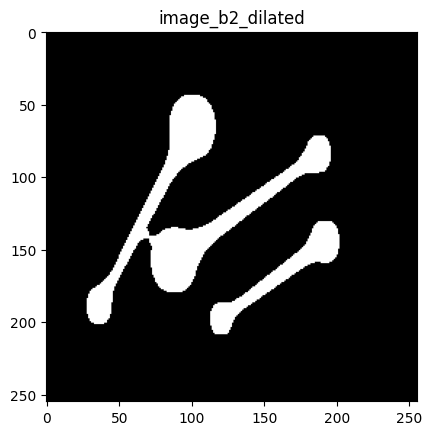

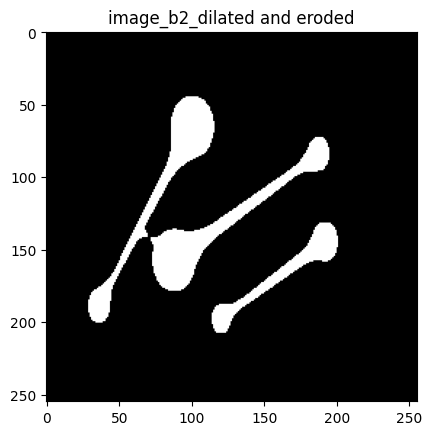

In [592]:
########## Closing: done in two steps (dilate then erode) so to have more freedom in using different parameters

# Dilate a bit the dist image (to classify correctly the TESI00 image) (to correct possible broken parts e.g. TESI00)
kernel1 = np.ones((5,5), dtype=np.uint8)
image_b2_dilated = cv2.dilate(image_b2, kernel1)

plt.imshow(image_b2_dilated,'gray') 
plt.grid(False)
plt.title('image_b2_dilated')
# plt.savefig(f'out_watershed_plus_mf_{image_to_load}.png')
plt.show()

# Erode im_out in order to divide better the connected regions (if we did it right after the cv2.dilate the dividing pixels would be not enough to separate the neatly the touching objects)
kernel2 = np.ones((3,3), dtype=np.uint8)
image_b2_dilated = cv2.erode(image_b2_dilated, kernel2)

plt.imshow(image_b2_dilated,'gray') 
plt.grid(False)
plt.title('image_b2_dilated and eroded')
# plt.savefig(f'out_watershed_plus_mf_{image_to_load}.png')
plt.show()


We create the markers and we apply the ***Watershed Algorithm***

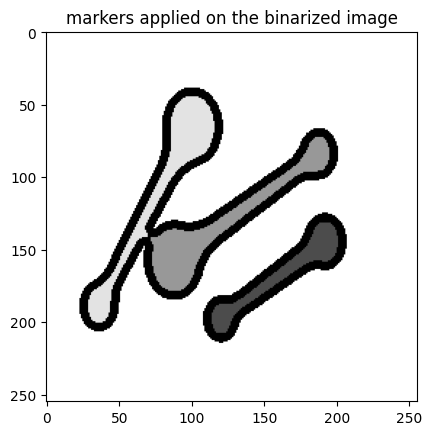

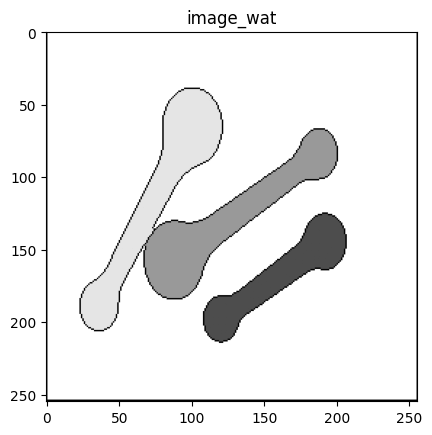

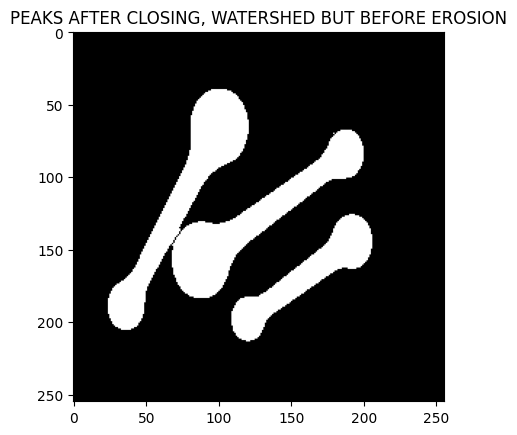

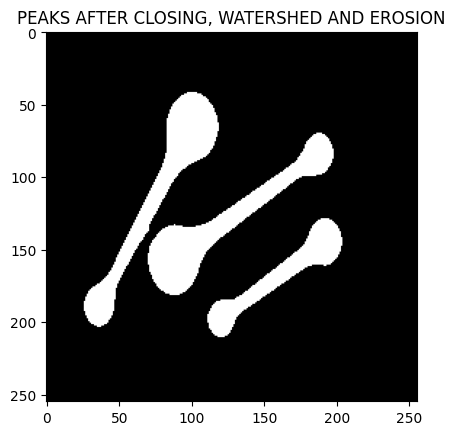

In [593]:
########################## MARKERS ######################################
# Create the CV_8U version of the distance image
# It is needed for findContours()
image_b2_dilated_8u = image_b2_dilated.astype('uint8')
 
contours, _ = cv2.findContours(image_b2_dilated_8u, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create and initialize the marker image for the watershed algorithm (based on the objects contour)
markers = np.zeros(image_b2.shape, dtype=np.int32)

# Draw the foreground markers
for i in range(len(contours)):
    cv2.drawContours(markers, contours, i, (int(230/len(contours))*(i+1)), -1) 
    # (int(230/len(contours))*(i+1)) is used for better human visualization 
    
# Draw the background marker ???
# Draw
markers += 255 - image_combined.astype('uint8')

# Plot
plt.imshow(markers,'gray') 
plt.grid(False)
plt.title('markers applied on the binarized image')
# plt.savefig(f'image_wat_{image_to_load}.png')
plt.show()

# From GRAY to RGB scale
image_combined_colored = cv2.cvtColor(image_combined, cv2.COLOR_GRAY2RGB)

# Perform the watershed algorithm
image_wat = cv2.watershed(image_combined_colored, markers)

# Plot
plt.imshow(image_wat,'gray')
plt.grid(False)
plt.title('image_wat')
# plt.savefig(f'image_wat_{image_to_load}.png')
plt.show()

# put the contour in black to mark better the separation.
image_combined_colored[image_wat == -1] = [0,0,0] 

# Plot
plt.imshow(image_combined_colored,'gray')
plt.grid(False)
plt.title('PEAKS AFTER CLOSING, WATERSHED BUT BEFORE EROSION')
# plt.savefig(f'out_watershed_plus_mf_{image_to_load}.png')
plt.show()

# Erode "image_combined_colored" in order to divide better the connected region in TESI50 
kernel2 = np.ones((5,5), dtype=np.uint8)
image_eroded = cv2.erode(image_combined_colored, kernel2)

# From RGB to GRAY scale
image_gray = cv2.cvtColor(image_eroded, cv2.COLOR_RGB2GRAY)

# Plot
plt.imshow(image_gray,'gray') 
plt.grid(False)
plt.title('PEAKS AFTER CLOSING, WATERSHED AND EROSION')
# plt.savefig(f'out_watershed_plus_mf_{image_to_load}.png')
plt.show()

In order to proceed with the analysis we ***reintroduce the holes*** in the right place. It is necessary to erode the inverted floodfill image to reintroduce correctly the holes.

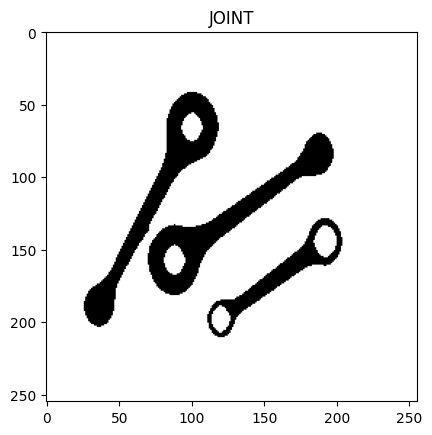

In [594]:
kernel3 = np.ones((7,7), dtype=np.uint8)

image_floodfill_inv = cv2.erode(image_floodfill_inv, kernel3)

# image_out = above image inverted + white holes
image_out = (255-image_gray) + (image_floodfill_inv)

plt.imshow(image_out,'gray') 
plt.grid(False)
plt.title('JOINT')
# plt.savefig(f'out_before_labeling_{image_to_load}.png')
plt.show()

We compute again the baricenters for the convenience of having only the interesting components inside the dictionary. Now we have clean images of the rods without distractions like powder, screws and washers.

In [595]:
Barycenter = {}
Barycenter_contours = {}
contours, hierarchy, Barycenter_contours, Barycenter = Barycenter_computation(image_out, Barycenter_contours, Barycenter)

# CLASSIFICATION OF THE OBJECTS IN THE IMAGE
Since we removed all possible distractors before, we can only have in the image: ROD_A, ROD_B.

In order to correctly classify them we will look at the hierarchy structure of the contours:
- If it has two holes (classified as "child"), it will be classified as ROD_B.
- If it has only one hole (classified as "child"), and the barycenter of the child and of the object we are analyzing are different, it will be classified as ROD_A.


{1: 2, 4: 1, 6: 1}
{2: 'HOLE', 3: 'HOLE', 5: 'HOLE', 7: 'HOLE', 1: 'ROD_B', 4: 'ROD_A', 6: 'ROD_A'}


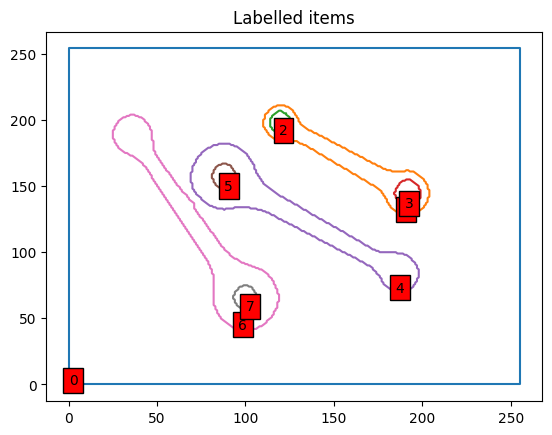

In [596]:
Dict_info_contours = {}
Dict_number_holes = {}  # it stores the number of holes, only of the rods. This is a dictionary made of {key0: value0, key1: value1,...}

for i in range(len(contours)):  # for each contour:    
    if hierarchy[0][i][2] == -1:  # this contour has no child --> it's not a rod (it's a hole or a screw)
        # we use hierarchy[0] because there is no other hierarchy level. 
        # In our case there are never elements inside the holes.
        
        if hierarchy[0][i][3] != -1: # it has no child but has a parent --> it's a hole
            # for every contour we check, if it has a parent then we can increment the number of holes of the parent
            Dict_info_contours[i] = 'HOLE'
            # I store the info that its parent has an hole:
            Dict_number_holes[hierarchy[0][i][3]] = Dict_number_holes.get(hierarchy[0][i][3],0) + 1 
            # summing the number of holes in the key of the parent (hierarchy[0][i][3] this is the key of the parent)
            # search the value of the key "hierarchy[0][i][3]" and add 1, 
            # return 0 if you don't find the key in the dictionary

print(Dict_number_holes) # {label of the 1st item: number of holes, label of the 2nd item: number of holes, etc...}

#[probabilmente farlo in maniera diversa]

for key,value in Dict_number_holes.items():
    # if there is 1 hole, then it's a rod of type A
    if value == 1:
        Dict_info_contours[key] = 'ROD_A'

    # if there are 2 holes, then it's a rod of type B
    if value == 2:
        Dict_info_contours[key] = 'ROD_B'

print(Dict_info_contours) # {label of the 1st item: type of item, etc...}

for i in range(len(contours)):
    plt.plot(contours[i][:,0][:,0],contours[i][:,0][:,1])
    plt.text(contours[i][0][0][0],contours[i][0][0][1],i,bbox=dict(facecolor='red', alpha=1))

plt.title("Labelled items")
plt.show()


# COMPUTATION OF THE DIAMETERS OF THE CONNECTING ROD HOLES

This code computes the diameters of the holes of the rods based on the maximum and minimum value of the $i,j$ coordinates of the holes.

{2: 13.0, 3: 16.0, 5: 15.0, 7: 14.5}


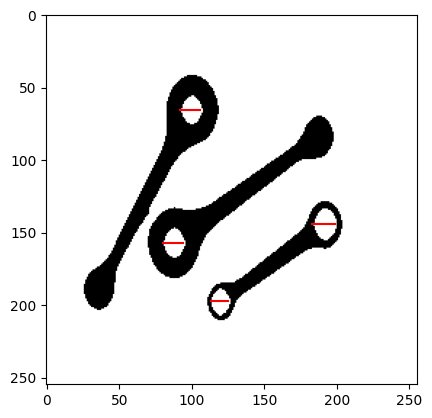

In [597]:
plt.imshow(image_out, cmap='gray', vmin=0, vmax=255);
Dict_hole_diameters = {}
Dict_hole_barycenters = {}
        
for key,value in Dict_info_contours.items():   
     
    if value == 'HOLE': # examinate only holes       
        barycenter = Barycenter[key] # take the barycenter value (+1 to not include the background)

        # extract the edges of the hole in the i,j pixel coordinates
        min_i = min(contours[key][:,0][:,0]) 
        max_i = max(contours[key][:,0][:,0]) 
        min_j = min(contours[key][:,0][:,1]) 
        max_j = max(contours[key][:,0][:,1])                

        # compute the diameter (average between the i direction and j direction)
        Dict_hole_diameters[key] = ((max_i - min_i - 2) + (max_j - min_j - 2)) / 2 # np.mean([max_i - min_i -2 , max_j - min_j])
        # The -2 in the previous average is used to avoid counting the initial and final pixel of the diameter
        radius = Dict_hole_diameters[key]/2
        Dict_hole_barycenters[key] = barycenter 
        plt.plot(np.linspace(barycenter[0]-int(radius), barycenter[0]+int(radius)), np.ones(50)*barycenter[1], 'r')  
            
print(Dict_hole_diameters)

# WIDTH AT THE BARYCENTER $W_B$
In order to find the width of the rods we need to find the minimum distance between the barycenter and the nearest contours, then we exploit the symmetry of the item we are working with to compute the final value.

How to read `contours[label][:,0][:,0]`: with label you decide with blob (row) you are analyzing, the first `[:,0]` means that you take all the element in the column 0 (there is only one column in our case), then with the last `[:,0]` or `[:,1]` you select if you want to extract the first $(i)$ or the $(j)$.

In [598]:
Dict_width_barycenter = {}

for label in range(1,len(contours)): # start from item 1 to avoid the background (item 0)    
    if Dict_info_contours[label] == 'ROD_A' or Dict_info_contours[label] == 'ROD_B': #taking into analysis only rod A and rod B
        i_coord_contour = contours[label][:,0][:,0] # take the i element of the contour of the "label" rod
        j_coord_contour = contours[label][:,0][:,1] # take the j element of the contour of the "label" rod
        bar = Barycenter[label] # assign to the temporary bar variable the barycenter of the rod
        
        min_dist = 10000 # random value to initialize since we want to find a minimum
        for i in range(len(i_coord_contour)):
            dist_bar = ( (bar[0] - i_coord_contour[i])**2 + (bar[1] - j_coord_contour[i])**2 ) ** (1/2) # square root of the sum of the distance find the minimum distance between the barycenter and the contour
            if dist_bar < min_dist: # find the min distance to the contour
                min_dist = dist_bar # assign the minimum distance
        Dict_width_barycenter[label] = min_dist*2 # finally, just mult by 2 to have the width because of the symmetry of the rod
 

# ORIENTATION, LENGTH, WIDTH
We can use the function `minAreaRect` which computes all needed values related to the Minimum Area Rectangle (MER) so: length (or height), width and orientation wrt to the horizontal axis.

Note that the angle that the function will return a value $\in [0, \pi]$


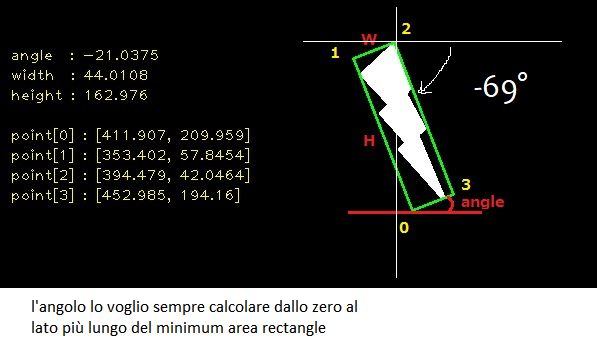

In [603]:
# dictionaries to store MER data
Dict_orientation_rod = {}
Dict_length_rod = {}
Dict_width_rod = {}

########## CREATION OF THE MER 

for key,value in Dict_info_contours.items():
    
    # we must do it only for rods:
    if value == 'ROD_A' or value == 'ROD_B':
        
        rect = cv2.minAreaRect(contours[key])
        orientation = rect[2]
        
        if rect[1][0] == max(rect[1][0],rect[1][1]): # compare the two sides of the rectangle, the longer one is the length
            length = rect[1][0]
            width = rect[1][1]
            Dict_orientation_rod[key] = abs(orientation)
            
        else:
            length = rect[1][1]
            width = rect[1][0]
            Dict_orientation_rod[key] = -1*(90+orientation) # see picture above
        
        #store informations:
        Dict_length_rod[key] = length
        Dict_width_rod[key] = width



((157.8292694091797, 171.53659057617188), (29.985363006591797, 114.31919860839844), 51.34019088745117)
((131.26010131835938, 120.12158966064453), (43.959110260009766, 156.84292602539062), 49.497154235839844)
((73.72096252441406, 124.44819641113281), (39.02741622924805, 176.86773681640625), 24.20927619934082)


# RESULTING IMAGES
ROD_A has 1 hole, while ROD_B has 2 holes.

hole diameters:          {2: 13.0, 3: 16.0, 5: 15.0, 7: 14.5}
hole barycenters:        {2: [119, 197], 3: [191, 144], 5: [87, 157], 7: [99, 65]}
width at the barycenter: {1: 10.0, 4: 12.649110640673518, 6: 10.770329614269007}
orientation in degree:   {1: -141.34019088745117, 4: -139.49715423583984, 6: -114.20927619934082}
length:                  {1: 114.31919860839844, 4: 156.84292602539062, 6: 176.86773681640625}
width max rods:          {1: 29.985363006591797, 4: 43.959110260009766, 6: 39.02741622924805}
object classification:   {2: 'HOLE', 3: 'HOLE', 5: 'HOLE', 7: 'HOLE', 1: 'ROD_B', 4: 'ROD_A', 6: 'ROD_A'}


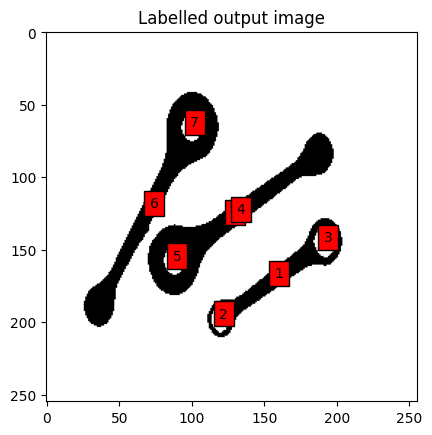

In [604]:
print('hole diameters:         ', Dict_hole_diameters)
print('hole barycenters:       ', Dict_hole_barycenters)
print('width at the barycenter:', Dict_width_barycenter)
print('orientation in degree:  ', Dict_orientation_rod)
print('length:                 ', Dict_length_rod)
print('width max rods:         ', Dict_width_rod) 
print('object classification:  ', Dict_info_contours)

plt.imshow(image_out, cmap='gray', vmin=0, vmax=255);
plt.title('Labelled output image')

# see the result on image_denoised, image_out, image

for label,bar in Barycenter.items(): 
    plt.text(bar[0], bar[1], label, bbox=dict(facecolor='red', alpha=1)) 
    plt.scatter(Barycenter[label][0],Barycenter[label][1], color='white')
    # plt.savefig(f'out_final_{image_to_load}.png')

plt.show()